In [47]:
#basic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from unyt import kW, minute, hr, day, MW
import sys

# osier imports
from osier import DispatchModel
from osier import CapacityExpansion
import osier.tech_library as lib

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination.ftol import MultiObjectiveSpaceTermination
from pymoo.termination.robust import RobustTermination

# automatically set the solver
if "darwin" in sys.platform:
    solver = 'cplex_direct'
print(f"Solver set: {solver}")

Solver set: cplex_direct


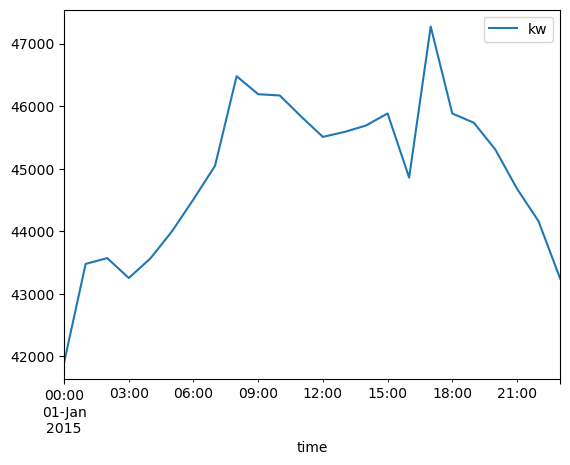

In [49]:
#importing actual UIUC demand data
url = "https://raw.githubusercontent.com/samgdotson/2021-dotson-ms/refs/heads/master/data/uiuc_demand_data.csv"
demand_data = pd.read_csv(url, usecols=['time', 'kw'], parse_dates=True,index_col='time')
dem_vals = demand_data.loc['2015-01-01']
dem_vals.plot();plt.show()

#establishing demand data for running in the simulation
demand = dem_vals['kw'].values

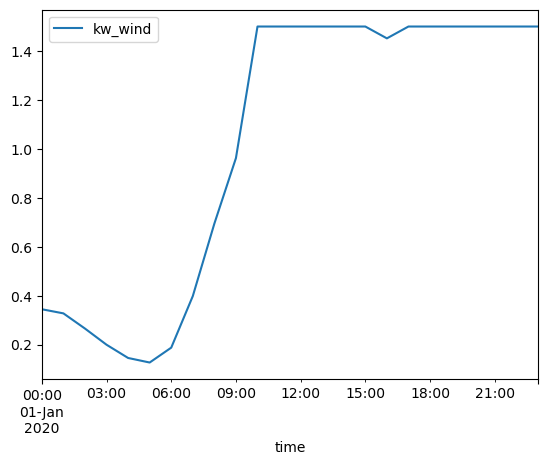

In [50]:
#importing wind data
url = "https://raw.githubusercontent.com/samgdotson/2021-dotson-ms/refs/heads/master/data/nsrdb_data/windHistory_2020.csv"
wind_power_data = pd.read_csv(url, usecols=['time', 'kw_wind'], parse_dates=True,index_col='time')
wind_power = wind_power_data.loc['2020-01-01']
wind_power.plot();plt.show()

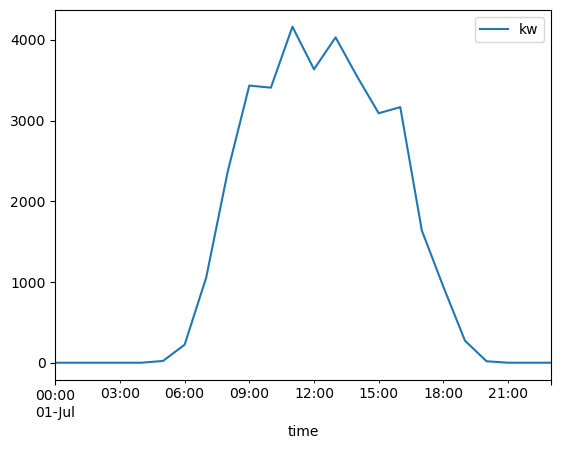

In [51]:
url = "https://raw.githubusercontent.com/samgdotson/2021-dotson-ms/refs/heads/master/data/solarfarm_data.csv"
solar_power = pd.read_csv(url, usecols=['time', 'kw'], parse_dates=True, index_col='time')

# choose a single day
solar_day = solar_power.loc['2016-07-01']
solar_day.plot();plt.show()

In [52]:
#getting the energy production values to run in the model

#solar power
solar_day_ener = solar_day['kw'].values
df_solar = pd.DataFrame(solar_day_ener, columns=['Energy'])
solar_ener = df_solar['Energy'].values

#wind power
wind_ener = wind_power['kw_wind'].values


In [53]:
#creating energy mix

#based off osier documentation, we need to include geothermal and add the capacity for coal
#adding capacity of coal, based on research
from osier.tech_library import coal

#finally, create the necessary energy mix
UIUC_mix = [lib.natural_gas,lib.coal,lib.solar,lib.wind]
display(UIUC_mix)


[NaturalGas_Conv: 8375.1331 MW,
 Coal_Conv: 0.0 MW,
 SolarPanel: 2810.3015 MW,
 WindTurbine: 0.0 MW]

In [54]:
#now wanting to do a multi-objective run
#considered total cost, lets consider limitng CO2 emissions
from osier import annual_emission, total_cost
problem2 = CapacityExpansion(technology_list = UIUC_mix,
                            demand=demand*kW,
                            solar=solar_ener,
                            wind=wind_ener,
                            upper_bound= 1 / lib.solar.capacity_credit,
                            objectives = [total_cost,annual_emission],
                            solver=solver)  # the objectives must be passed as a LIST of functions!

In [55]:
algorithm = NSGA2(pop_size=20)
termination = RobustTermination(MultiObjectiveSpaceTermination(tol=0.05, n_skip=5), period=20)
import time
start = time.perf_counter()
res = minimize(problem2,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      3 |             - |             -


KeyboardInterrupt: 

In [27]:
#displaying multi-objective results
display(res.F),display(res.X)

array([[9.35887312e-01, 1.60821346e-04],
       [5.97348339e+00, 1.86278096e-05],
       [5.14702766e+00, 1.90739791e-05],
       [1.38357580e+00, 7.82150938e-05],
       [4.57517105e+00, 2.09822884e-05],
       [4.06171754e+00, 2.29652457e-05],
       [1.52452626e+00, 6.24089615e-05],
       [2.19044490e+00, 3.48002965e-05],
       [1.04011188e+00, 1.47920345e-04],
       [2.84248003e+00, 2.97194899e-05],
       [1.33496251e+00, 9.16857251e-05],
       [1.05880092e+00, 1.32180107e-04],
       [1.13929353e+00, 1.22034698e-04],
       [1.77941225e+00, 5.13524283e-05],
       [5.83888795e+00, 1.90064017e-05],
       [3.00017342e+00, 2.88248201e-05],
       [1.14501713e+00, 1.07521554e-04],
       [1.21372639e+00, 1.02135376e-04],
       [3.52364559e+00, 2.59508230e-05],
       [2.15127880e+00, 4.20345976e-05]])

array([[9.83499756e-01, 7.51184392e-03, 3.08456509e-04, 1.14176248e-02],
       [3.74494986e-01, 1.94026974e-06, 1.99529169e-05, 3.79585161e+00],
       [2.98269215e-01, 2.38150784e-05, 1.85630988e-04, 3.28555905e+00],
       [5.89319214e-01, 2.90250681e-04, 8.72450124e-02, 5.28462474e-01],
       [4.27811854e-01, 1.21011865e-04, 3.10572670e-03, 2.81860819e+00],
       [3.88893411e-01, 1.75137936e-04, 8.61717636e-03, 2.49392228e+00],
       [5.54942226e-01, 1.50338204e-05, 3.24306983e-03, 6.82040380e-01],
       [5.28674291e-01, 1.50643744e-05, 3.24306983e-03, 1.14809377e+00],
       [9.97253475e-01, 2.90250681e-04, 1.67246656e-01, 8.13729112e-03],
       [4.81565606e-01, 1.71995586e-04, 3.58549058e-04, 1.61805360e+00],
       [6.96502660e-01, 8.02772402e-04, 2.37703779e-01, 3.63114014e-01],
       [7.87895314e-01, 1.02866197e-02, 9.01495288e-03, 2.09343085e-01],
       [8.04717614e-01, 6.61023226e-04, 3.36374234e-02, 2.52427745e-01],
       [6.70364141e-01, 6.45681657e-05, 2.35065789e

(None, None)

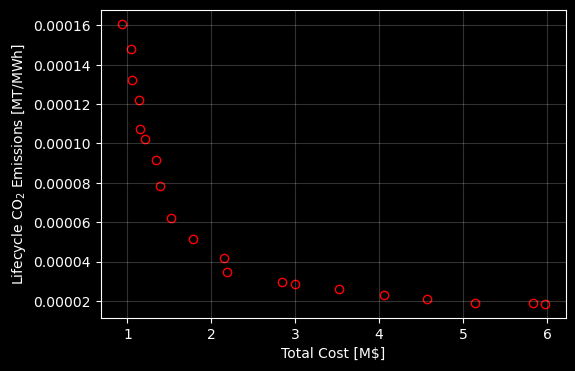

In [28]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    ax.scatter(res.F[:,0], res.F[:,1], edgecolors='red', facecolors='k')
    ax.set_ylabel(r"Lifecycle CO$_2$ Emissions [MT/MWh]")
    ax.set_xlabel(r"Total Cost [M\$]")
    ax.grid(alpha=0.2)

    plt.show()